In [197]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib

import os
import numpy as np
import sys
sys.path.append("..")
from scripts.utils import get_path, get_noise_in_estimator
from vis_utils.loaders import load_dataset, label_to_color, label_to_time
from vis_utils.utils import compute_normalization
import pickle
import cne


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [198]:
root_path = get_path("data")
fig_path = get_path("figures")

In [199]:
# parameters for all methods
seeds = [0, 1, 2]

dataset = "toy"
k = 2

In [200]:
plt.style.use("default")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["font.family"] = "serif"
plt.rcParams['font.serif'] = "Times New Roman"

In [201]:
x, y, sknn, pca2 = load_dataset(root_path, dataset, k=k)

In [202]:
x

array([[0.       , 0.       ],
       [1.       , 0.       ],
       [0.5      , 0.8660254]])

In [203]:
pca2

array([[-0.5       , -0.28867513],
       [ 0.5       , -0.28867513],
       [ 0.        ,  0.57735027]])

In [204]:
sknn.todense()

matrix([[0., 1., 1.],
        [1., 0., 1.],
        [1., 1., 0.]])

In [205]:
# parameters
parametric = False
log_embds = True
log_norms = True
log_kl = False
optimizer = "sgd"
n_epochs = 750
loss_mode = "neg_sample"
n_noise = 5
batch_size = 6  # full batch GD, there are 6 nonzero entries in the sknn adjacency matrix
rescale = 1.0
anneal_lr = True
momentum=0.0
learning_rate = 0.01
lr_min_factor=0.0
clamp_low = 1e-10
on_gpu = True
init_type = "pca"

In [206]:
# main optimization phase
nbs_noise_in_estimator = (np.insert(np.linspace(0, 7, 15) +0.5, 0, 0.01)) *n_noise * 4 / 33  # exact value of the noise distribution at such a low batch size, confer appendix on the noise distribution
seeds = [0, 1, 2]
final_norms = np.empty((len(nbs_noise_in_estimator), len(seeds)))
for i, noise_in_estimator in enumerate(nbs_noise_in_estimator):
    for j, seed in enumerate(seeds):
        file_name = os.path.join(root_path,
                             dataset,
                             f"cne_{loss_mode}_n_noise_{n_noise}_noise_in_estimator_{noise_in_estimator}_n_epochs_{n_epochs}_init_pca_bs_{batch_size}"
                             f"_optim_{optimizer}_anneal_lr_{anneal_lr}_lr_min_factor_{lr_min_factor}_momentum_{momentum}_param_{parametric}_clamp_low_{clamp_low}_seed_{seed}.pkl"
                             )

        try:
            with open(file_name, "rb") as file:
                embedder_cne = pickle.load(file)
        except FileNotFoundError:
            logger = cne.callbacks.Logger(log_embds=log_embds,
                                          log_norms=log_norms,
                                          log_kl=log_kl,
                                          graph=sknn,
                                          n=len(x) if parametric else None)
            embedder = cne.CNE(loss_mode=loss_mode,
                               parametric=parametric,
                               negative_samples=n_noise,
                               n_epochs=n_epochs,
                               batch_size=batch_size,
                               on_gpu=on_gpu,
                               print_freq_epoch=None,
                               print_freq_in_epoch=None,
                               callback=logger,
                               optimizer=optimizer,
                               momentum=momentum,
                               save_freq=1,
                               anneal_lr=anneal_lr,
                               noise_in_estimator=noise_in_estimator,
                               lr_min_factor=lr_min_factor,
                               clamp_low=clamp_low,
                               seed=seed,
                               learning_rate=learning_rate,
                               loss_aggregation="sum",
                               force_resample=True
                               )
            embedder.fit(x, init=pca2, graph=sknn)
            embedder_cne = embedder.cne

            with open(file_name, "wb") as file:
                pickle.dump(embedder_cne, file, pickle.HIGHEST_PROTOCOL)

        embd = embedder_cne.callback.embds[-1]
        final_norms[i, j] = compute_normalization(embd)
    print(f"Done with noise_in_estimator {noise_in_estimator}")

Done with noise_in_estimator 0.006060606060606061
Done with noise_in_estimator 0.30303030303030304
Done with noise_in_estimator 0.6060606060606061
Done with noise_in_estimator 0.9090909090909091
Done with noise_in_estimator 1.2121212121212122
Done with noise_in_estimator 1.5151515151515151
Done with noise_in_estimator 1.8181818181818181
Done with noise_in_estimator 2.121212121212121
Done with noise_in_estimator 2.4242424242424243
Done with noise_in_estimator 2.727272727272727
Done with noise_in_estimator 3.0303030303030303
Done with noise_in_estimator 3.3333333333333335
Done with noise_in_estimator 3.6363636363636362
Done with noise_in_estimator 3.9393939393939394
Done with noise_in_estimator 4.242424242424242
Done with noise_in_estimator 4.545454545454546


In [207]:
mean = final_norms.mean(1)
std = final_norms.std(1)

zbar = nbs_noise_in_estimator / n_noise / (4/33)


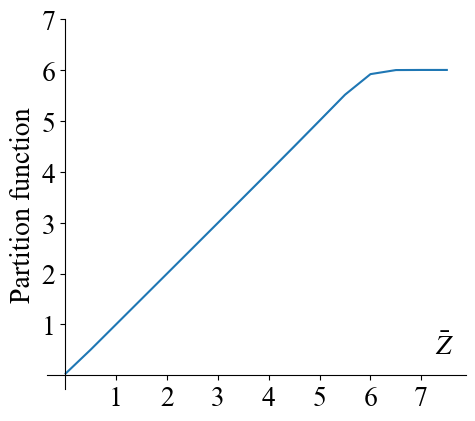

In [210]:
fontsize=20
plt.plot(zbar, mean)
plt.fill_between(zbar, mean-std, mean+std, alpha=0.5)

#plt.plot(zbar, zbar, linestyle="dotted", c="k")
plt.xlabel(r"$\bar{Z}$", fontsize=fontsize)
plt.gca().xaxis.set_label_coords(0.95, 0.15)
plt.ylabel("Partition function", fontsize=fontsize)


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_position(('data', 0))
plt.gca().spines['bottom'].set_position(('data', 0))
plt.xticks([1,2,3,4,5,6,7],fontsize=fontsize)
plt.yticks([1,2,3,4,5,6,7], fontsize=fontsize)


plt.gca().set_aspect("equal")
plt.savefig(os.path.join(fig_path,
                         f"toy_partition.png"),
            bbox_inches='tight',
            pad_inches=0.1,
            dpi=200)